In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime

In [3]:
raw_df = pd.read_csv('rosbank_train.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [4]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
target_sum      490513 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000251788BA128>,
      dtype=object)

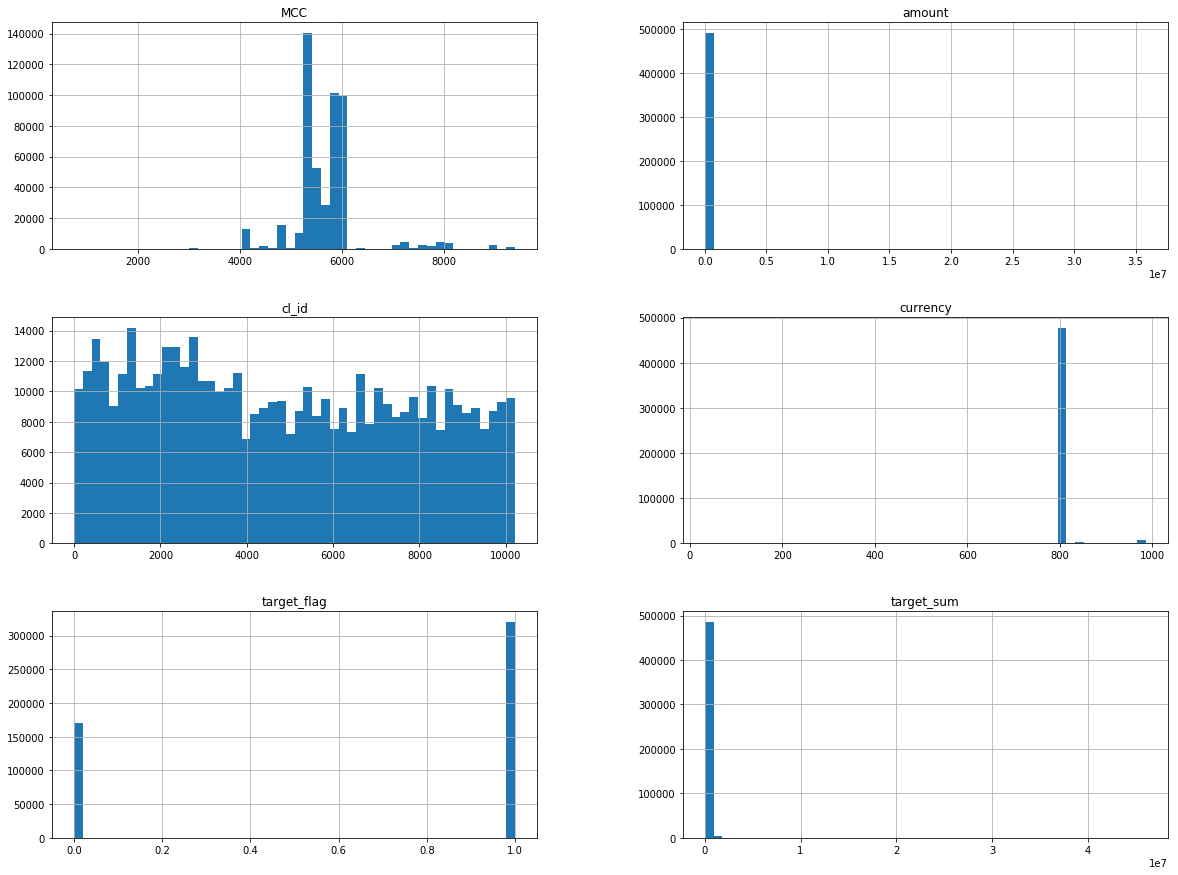

In [13]:
#посмотрим на данные
raw_df.hist(bins=50, figsize=(20,15))

По гистограммам МСС, трат, валют видим, что есть наиболее часто встречающиеся значения, но есть и выбросы, например суммы транзакций выше десятков миллионов. Скорее всего это связано с разными валютами. Можно привести все к одной, но в рамках текущей задачи это несущественно. Отбирать наиболее популярные МСС, каналы и категории тоже смысла особого нет. А вот валюты можно отобрать три наиболее популярные

In [14]:
raw_df.corr()

,cl_id,MCC,currency,amount,target_flag,target_sum
cl_id,1.000000,-0.004789,0.000630,0.002446,-0.410436,-0.075423
MCC,-0.004789,1.000000,0.000547,0.019986,0.013118,-0.017400
currency,0.000630,0.000547,1.000000,-0.040777,-0.013644,-0.002662
amount,0.002446,0.019986,-0.040777,1.000000,-0.003336,-0.001133
target_flag,-0.410436,0.013118,-0.013644,-0.003336,1.000000,0.080548
target_sum,-0.075423,-0.017400,-0.002662,-0.001133,0.080548,1.000000


Корреляций нет

In [15]:
#наиболее популярные MCC - Бакалейные магазины, супермаркеты

raw_df['MCC'].value_counts()

5411    121640
6011     54382
5814     41351
5812     30027
5499     27237
5541     19816
5912     18728
5999     13073
6012     10056
5921      8578
5331      7641
4121      6266
5211      6262
4829      6205
5691      5161
5261      4803
4111      4362
5977      4300
5200      3460
5732      3271
5311      3258
5533      2946
5651      2915
4812      2857
5641      2710
8099      2674
5722      2667
5661      2601
8999      2599
5941      2597
         ...  
3064         1
3678         1
8675         1
3548         1
3607         1
3730         1
3029         1
3535         1
3722         1
7333         1
7339         1
3387         1
3715         1
3508         1
3640         1
3513         1
3515         1
3191         1
5937         1
3634         1
3520         1
7217         1
3659         1
3628         1
3778         1
5960         1
3625         1
7211         1
7631         1
3703         1
Name: MCC, Length: 344, dtype: int64

In [16]:
#посмотрим валюты
raw_df['currency'].value_counts()

810    477644
978      5536
840      1921
933       561
985       423
764       412
203       399
949       390
975       297
826       267
784       262
980       209
392       197
981       164
348       151
756       126
578       110
410       110
752       109
702       100
398        99
191        95
360        72
156        70
51         60
376        60
352        59
484        53
704        52
124        41
356        40
144        40
417        35
498        35
344        34
643        32
480        32
214        31
944        31
554        27
458        20
36         17
32         12
986        12
208        12
504        11
690         8
941         8
901         5
946         4
604         3
170         3
462         2
44          2
608         2
634         2
710         2
188         1
788         1
Name: currency, dtype: int64

In [5]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


In [6]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [7]:
# create transactions dataset for train
tr_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in train dataset: ", len(tr_train))
# create transactions dataset for test
tr_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()
print("Total transactions in test dataset: ", len(tr_test))

Total transactions in train dataset:  388156
Total transactions in test dataset:  102357


In [47]:
#заполним недостающие значения опцией "unknown"
tr_train['channel_type'].fillna(value='unknown', inplace=True)

In [48]:
df = tr_train
#добавим колонку - день недели транзакции
df['day_of_transaction'] = df['TRDATETIME'].apply(
    lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
) 

#посмотрим кол-во транзакций по дням недели (взято из примера и переработано для понимания)
grouped_by_days=df.groupby(
    ['cl_id','day_of_transaction']
)['day_of_transaction'].size().unstack().fillna(0)

grouped_by_days.rename(columns=lambda x: 'day_'+str(x), inplace=True)
grouped_by_days.head()

day_of_transaction,day_0,day_1,day_2,day_3,day_4,day_5,day_6
cl_id,,,,,,,
0,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,7.0,20.0,20.0,16.0,16.0,10.0,15.0
5,15.0,19.0,19.0,15.0,25.0,24.0,25.0
10,74.0,35.0,62.0,68.0,65.0,57.0,102.0
11,28.0,29.0,30.0,25.0,40.0,40.0,25.0


In [49]:
#добавим колонку - час транзакции
df['hour_of_transaction'] = df['TRDATETIME'].apply(
    lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
) 
    
#посмотрим кол-во транзакций часам
grouped_by_hours=df.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0)

grouped_by_hours.rename(columns=lambda x: 'hour_'+str(x), inplace=True)
grouped_by_hours.head()

hour_of_transaction,hour_00,hour_01,hour_02,hour_03,hour_04,hour_05,hour_06,hour_07,hour_08,hour_09,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
cl_id,,,,,,,,,,,,,,,,,,,,,
0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,101.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0
5,124.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,1.0,4.0,5.0,2.0,0.0,0.0,0.0,0.0
10,299.0,3.0,6.0,8.0,14.0,9.0,19.0,17.0,13.0,12.0,...,6.0,3.0,4.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0
11,207.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,3.0,0.0,2.0,0.0,0.0,0.0,0.0


In [50]:
#общие расходы по трем самым популярным валютам

gr_cur = df[['cl_id', 'amount', 'currency']][df['currency'].isin([810,978,840])].groupby(['cl_id', 'currency']).agg(['sum']).unstack().fillna(0)
gr_cur.rename(columns=lambda x: 'cur_sum_'+str(x), inplace=True);
gr_cur.columns = gr_cur.columns.get_level_values(2)
gr_cur.head()

currency,cur_sum_810,cur_sum_840,cur_sum_978
cl_id,,,
0,64383.00,0.0,0.00
1,266693.13,0.0,884.91
5,544874.63,0.0,51.83
10,1124343.99,0.0,0.00
11,427662.85,0.0,84.29


In [51]:
def get_aggregated_df(df, agg_type, col_to_groupby):
    agg_df = df[['cl_id', col_to_groupby, 'amount']].groupby(['cl_id', col_to_groupby]).agg([agg_type])
    agg_df = agg_df.unstack(fill_value=0)
    agg_df.columns = agg_df.columns.get_level_values(2)

    old_name = agg_df.columns.name
    old_cols = agg_df.columns
    new_cols = [old_name + '_' + agg_type + '_' + str(old_col) for old_col in old_cols]
    agg_df.rename(
        columns={old_col: new_col for old_col, new_col in zip(old_cols, new_cols)}, inplace=True
    )
    return agg_df

In [52]:
#сумма и кол-во по МСС
gr_mcc = pd.merge(
    get_aggregated_df(df, 'count', 'MCC'),
    get_aggregated_df(df, 'sum', 'MCC'),
    left_index = True,
    right_index = True
)
gr_mcc.head()

MCC,MCC_count_742,MCC_count_763,MCC_count_780,MCC_count_1520,MCC_count_1711,MCC_count_1731,MCC_count_1750,MCC_count_1799,MCC_count_2741,MCC_count_2842,...,MCC_sum_8699,MCC_sum_8911,MCC_sum_8931,MCC_sum_8999,MCC_sum_9211,MCC_sum_9222,MCC_sum_9311,MCC_sum_9399,MCC_sum_9402,MCC_sum_9405
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,210.0,0.0,0.0,0.0
5,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,3825.0,0.0,0.0,0.0,0.0
10,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,2400.0,0.0,0.0,0.0,0.0,0.0,0.0
11,0,0,0,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [53]:
#среднее и кол-во по channel_type
gr_ctype = pd.merge(
    get_aggregated_df(df, 'count', 'channel_type'),
    get_aggregated_df(df, 'mean', 'channel_type'),
    left_index = True,
    right_index = True
)
gr_ctype.head()

channel_type,channel_type_count_type1,channel_type_count_type2,channel_type_count_type3,channel_type_count_type4,channel_type_count_type5,channel_type_count_unknown,channel_type_mean_type1,channel_type_mean_type2,channel_type_mean_type3,channel_type_mean_type4,channel_type_mean_type5,channel_type_mean_unknown
cl_id,,,,,,,,,,,,
0,0,0,0,0,0,5,0.0,0.0,0.0,0.0,0.0,12876.600000
1,0,0,0,0,0,104,0.0,0.0,0.0,0.0,0.0,2572.865769
5,0,0,0,0,0,142,0.0,0.0,0.0,0.0,0.0,3847.669930
10,0,0,0,0,0,463,0.0,0.0,0.0,0.0,0.0,2428.388747
11,0,0,0,0,0,217,0.0,0.0,0.0,0.0,0.0,1971.184977


In [54]:
#среднее и кол-во по trx_category
gr_tcat = pd.merge(
    get_aggregated_df(df, 'count', 'trx_category'),
    get_aggregated_df(df, 'mean', 'trx_category'),
    left_index = True,
    right_index = True
)
gr_tcat.head()

trx_category,trx_category_count_BACK_TRX,trx_category_count_C2C_IN,trx_category_count_C2C_OUT,trx_category_count_CASH_ADV,trx_category_count_CAT,trx_category_count_DEPOSIT,trx_category_count_POS,trx_category_count_WD_ATM_OTHER,trx_category_count_WD_ATM_PARTNER,trx_category_count_WD_ATM_ROS,trx_category_mean_BACK_TRX,trx_category_mean_C2C_IN,trx_category_mean_C2C_OUT,trx_category_mean_CASH_ADV,trx_category_mean_CAT,trx_category_mean_DEPOSIT,trx_category_mean_POS,trx_category_mean_WD_ATM_OTHER,trx_category_mean_WD_ATM_PARTNER,trx_category_mean_WD_ATM_ROS
cl_id,,,,,,,,,,,,,,,,,,,,
0,0,0,1,0,0,1,3,0,0,0,0.0,0.0,36562.000000,0.0,0.000000,20000.0,2607.000000,0.0,0.0,0.000000
1,0,0,0,0,0,2,101,0,0,1,0.0,0.0,0.000000,0.0,0.000000,47500.0,1213.643960,0.0,0.0,50000.000000
5,1,0,8,0,0,4,111,2,2,14,13990.0,0.0,4234.797500,0.0,0.000000,32500.0,2617.123874,2750.0,3000.0,4750.000000
10,0,1,19,0,3,24,374,0,3,39,0.0,10000.0,1141.731579,0.0,12564.993333,17762.5,537.315802,0.0,1800.0,10828.205128
11,0,0,0,0,0,10,207,0,0,0,0.0,0.0,0.000000,0.0,0.000000,18200.0,1187.184251,0.0,0.0,0.000000


In [55]:
add_df0 = pd.merge(
    grouped_by_days,
    grouped_by_hours,
    left_index = True,
    right_index = True
)

add_df1 = pd.merge(
    gr_cur,
    gr_mcc,
    left_index = True,
    right_index = True
)

add_df2 = pd.merge(
    gr_ctype,
    gr_tcat,
    left_index = True,
    right_index = True
)

train_df = pd.merge(
    add_df0,
    add_df1,
    left_index = True,
    right_index = True
)

train_df = pd.merge(
    train_df,
    add_df2,
    left_index = True,
    right_index = True
)

In [56]:
train_df.head()

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_00,hour_01,hour_02,...,trx_category_mean_BACK_TRX,trx_category_mean_C2C_IN,trx_category_mean_C2C_OUT,trx_category_mean_CASH_ADV,trx_category_mean_CAT,trx_category_mean_DEPOSIT,trx_category_mean_POS,trx_category_mean_WD_ATM_OTHER,trx_category_mean_WD_ATM_PARTNER,trx_category_mean_WD_ATM_ROS
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,...,0.0,0.0,36562.000000,0.0,0.000000,20000.0,2607.000000,0.0,0.0,0.000000
1,7.0,20.0,20.0,16.0,16.0,10.0,15.0,101.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,47500.0,1213.643960,0.0,0.0,50000.000000
5,15.0,19.0,19.0,15.0,25.0,24.0,25.0,124.0,0.0,0.0,...,13990.0,0.0,4234.797500,0.0,0.000000,32500.0,2617.123874,2750.0,3000.0,4750.000000
10,74.0,35.0,62.0,68.0,65.0,57.0,102.0,299.0,3.0,6.0,...,0.0,10000.0,1141.731579,0.0,12564.993333,17762.5,537.315802,0.0,1800.0,10828.205128
11,28.0,29.0,30.0,25.0,40.0,40.0,25.0,207.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,18200.0,1187.184251,0.0,0.0,0.000000


In [58]:
df_targets = raw_df[['cl_id', 'target_flag']].drop_duplicates().copy()
df_targets.index = df_targets['cl_id']
df_targets = df_targets.drop('cl_id', axis=1)
df_targets.head()

,target_flag
cl_id,
0,0
1,0
5,1
9,0
10,0


In [60]:
train_df = pd.merge(
    train_df,
    df_targets,
    left_index = True,
    right_index = True,
    how='inner'
)

In [61]:
train_df.head()

,day_0,day_1,day_2,day_3,day_4,day_5,day_6,hour_00,hour_01,hour_02,...,trx_category_mean_C2C_IN,trx_category_mean_C2C_OUT,trx_category_mean_CASH_ADV,trx_category_mean_CAT,trx_category_mean_DEPOSIT,trx_category_mean_POS,trx_category_mean_WD_ATM_OTHER,trx_category_mean_WD_ATM_PARTNER,trx_category_mean_WD_ATM_ROS,target_flag
cl_id,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,3.0,0.0,0.0,...,0.0,36562.000000,0.0,0.000000,20000.0,2607.000000,0.0,0.0,0.000000,0
1,7.0,20.0,20.0,16.0,16.0,10.0,15.0,101.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,47500.0,1213.643960,0.0,0.0,50000.000000,0
5,15.0,19.0,19.0,15.0,25.0,24.0,25.0,124.0,0.0,0.0,...,0.0,4234.797500,0.0,0.000000,32500.0,2617.123874,2750.0,3000.0,4750.000000,1
10,74.0,35.0,62.0,68.0,65.0,57.0,102.0,299.0,3.0,6.0,...,10000.0,1141.731579,0.0,12564.993333,17762.5,537.315802,0.0,1800.0,10828.205128,0
11,28.0,29.0,30.0,25.0,40.0,40.0,25.0,207.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,18200.0,1187.184251,0.0,0.0,0.000000,0


In [65]:
from sklearn.linear_model import LogisticRegression

In [70]:
clf = LogisticRegression()
X_train = train_df.drop(['target_flag'], axis=1)
y_train = train_df['target_flag']

In [71]:
clf.fit(X=X_train, y=y_train)

C:\Users\costa\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\costa\Anaconda3\lib\site-packages\sklearn\svm\base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [72]:
from sklearn.metrics import roc_auc_score, roc_curve

In [74]:
y_train_predict = clf.predict_proba(X_train)[:,1]

roc_auc_train = np.round(roc_auc_score(y_train, y_train_predict), 2)
print("Train: ", roc_auc_train)

Train:  0.77


In [75]:
import matplotlib

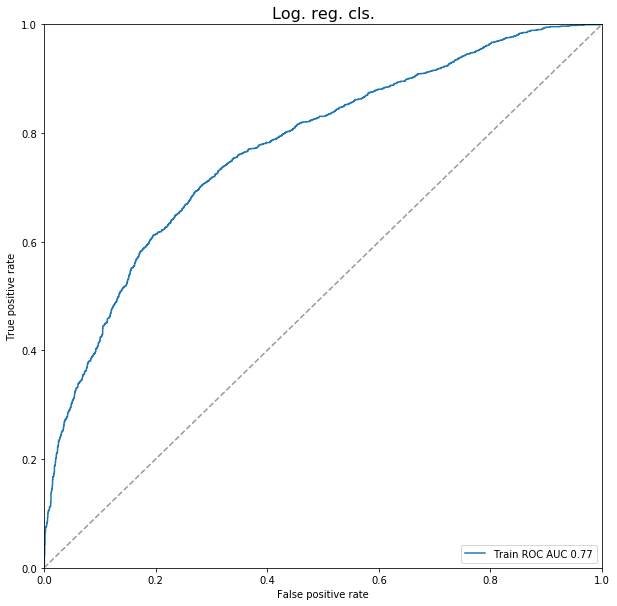

In [76]:
fpr_train, tpr_train, treshholds_train = roc_curve(y_train, y_train_predict)

matplotlib.rcParams['figure.figsize'] = (10.0, 10)
plt.plot(fpr_train, tpr_train, label='Train ROC AUC {0}'.format(roc_auc_train))
plt.plot([0,1],[0,1],'--', color=(0.6,0.6,0.6))
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('Logistic regression classifier', size=16)
plt.legend(loc='lower right')
plt.show()